<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/PoissonNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Session ?

## ??? ![gVXR](https://github.com/effepivi/gvxr-tutorials/blob/main/img/gvxr_logo.png?raw=1)

## Author: Franck Vidal

(version 1.0, 9 Mar 2023)

# Aims of this session

- 
- 
- 

![](https://github.com/effepivi/gvxr-tutorials/blob/main/img/noise.png?raw=1)

# Main steps

- 
- 
- 

# Copy files

This step is needed when the notebook is executed using Goggle Collaborative

In [2]:
parts_list = ["internals","coupler","front_flange","rear_flange","housing","roller_bearing"]

part_files = ["input_data/TurboPump/internals.stl",
               "input_data/TurboPump/coupler.stl",
               "input_data/TurboPump/front_flange.stl",
               "input_data/TurboPump/rear_flange.stl",
               "input_data/TurboPump/housing.stl",
               "input_data/TurboPump/ThrustRollerBearing.stl"]

Download the Sample if needed

In [3]:
import os
import urllib.request

def createDirectory(directory):
    # The directory does not exist
    if not os.path.exists(directory):
    
        # Create the directory
        os.mkdir(directory)

def downloadFile(fname):
    if not os.path.exists(fname):
        base_url = "https://github.com/effepivi/gvxr-tutorials/raw/main"
        url = base_url + "/" + fname
        print("Download the polygon mesh (%s)" % fname)
        urllib.request.urlretrieve(url, fname)

createDirectory("JSON")
createDirectory("input_data")
createDirectory("input_data/TurboPump")
createDirectory("PoissonNoise")
createDirectory("PoissonNoise/raw_projections")
createDirectory("PoissonNoise/reconstructions")

downloadFile("energyResponseDetector.txt")
downloadFile("JSON/PoissonNoise.json")

for fname in part_files:
    downloadFile(fname)

# Install gVXR, k3D and imagecodecs

Run the cell below

```python
!pip3 install --upgrade gvxr k3d imagecodecs
```

In [4]:
# !pip3 install --upgrade gvxr k3d imagecodecs xpecgen git+https://bitbucket.org/spekpy/spekpy_release.git

In [5]:
import matplotlib.pyplot as plt # Plotting
import numpy as np

from tifffile import imread, imwrite

from IPython.display import display
from IPython.display import Image

import SimpleITK as sitk

from cil.utilities.jupyter import islicer
from cil.processors import TransmissionAbsorptionConverter
from cil.utilities.display import show_geometry, show2D
from cil.recon import FBP, FDK
from cil.plugins.astra.processors.FDK_Flexible import FDK_Flexible
    
has_tigre = True
try:
    import tigre
    print("Tigre detected")
except:
    has_tigre = False
    print("Tigre not detected")

from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr
from gvxrPython3.JSON2gVXRDataReader import *
from gvxrPython3.utils import visualise
from gvxrPython3.utils import plotScreenshot

Tigre detected
SimpleGVXR 2.0.5 (2023-03-09T10:48:45) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.5 (2023-03-09T10:48:44) [Compiler: GNU g++] on Linux


## Initialise GVXR using our JSON file

In [6]:
json2gvxr.initGVXR("JSON/PoissonNoise.json")

Create an OpenGL context: 500x500


Thu Mar  9 17:40:40 2023 ---- Create window (ID: -1)
Thu Mar  9 17:40:41 2023 ---- Initialise GLFW
Thu Mar  9 17:40:41 2023 ---- Create an OpenGL window with a 3.2 context.
Thu Mar  9 17:40:43 2023 ---- Make the window's context current
Thu Mar  9 17:40:43 2023 ---- Initialise GLEW
Thu Mar  9 17:40:43 2023 ---- OpenGL vendor: NVIDIA Corporation
Thu Mar  9 17:40:43 2023 ---- OpenGL renderer: NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
Thu Mar  9 17:40:43 2023 ---- OpenGL version: 3.2.0 NVIDIA 525.85.12
Thu Mar  9 17:40:43 2023 ---- Use OpenGL 4.5.
Thu Mar  9 17:40:43 2023 ---- Initialise the X-ray renderer if needed and if possible


## Load our detector

In [7]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 20.0, 0.0, 'cm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [800, 800]
	Detector number of pixels: [800, 800]
	Energy response: ../energyResponseDetector.txt in MeV
	Pixel spacing: [0.8, 0.8, 'mm']


In [8]:
number_of_rows = json2gvxr.params["Detector"]["NumberOfPixels"][1]
number_of_cols = json2gvxr.params["Detector"]["NumberOfPixels"][0]

## Load our source properties

In [9]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, -60.0, 0.0, 'cm']
	Source shape: PointSource


In [10]:
spectrum, unit_of_energy, energy_set, bin_sets = json2gvxr.initSpectrum(verbose=0)

Thu Mar  9 17:40:46 2023 ---- Initialise the renderer


Extract the total energy and the number of incident photons

In [11]:
total_energy_MeV = gvxr.getTotalEnergyWithDetectorResponse()
number_of_incident_photons_per_pixel = sum(i for i in bin_sets)

print("The incident energy is", total_energy_MeV / gvxr.getUnitOfEnergy("keV"), "keV")
print("The number of incident photons is", number_of_incident_photons_per_pixel)

The incident energy is 61.073873192071915 keV
The number of incident photons is 2.020408163265307


A multiplicative factor to convert and image in keV into the number of photons

In [12]:
target_number_of_photons_per_pixel = 12000

In [13]:
energy2photons = number_of_incident_photons_per_pixel / total_energy_MeV

## Load our samples

In [14]:
json2gvxr.initSamples(verbose=1)

Load the 3D data

	Load internals in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/internals.stl using mm
	Load coupler in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/coupler.stl using mm
	Load front_flange in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/front_flange.stl using mm
	Load rear_flange in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/rear_flange.stl using mm
	Load housing in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/housing.stl using mm


Thu Mar  9 17:40:47 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/internals.stl	nb_faces:	86276	nb_vertices:	258828	bounding_box (in cm):	(-3.48613, -5.55, -3.48613)	(3.48613, -0.735, 3.48613)
Thu Mar  9 17:40:47 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/coupler.stl	nb_faces:	2532	nb_vertices:	7596	bounding_box (in cm):	(-4.13387, -11.365, -4.13387)	(4.13387, -5.55, 4.13387)
Thu Mar  9 17:40:47 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/front_flange.stl	nb_faces:	6120	nb_vertices:	18360	bounding_box (in cm):	(-11.425, 0, -11.425)	(11.425, 3.535, 11.425)
Thu Mar  9 17:40:47 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/rear_flange.stl	nb_faces:	10516	nb_vertices:	31548	bounding_box (in cm):	(-11.425, -15.535, -11.425)	(11.425, -6.73, 11.425)


	Load roller_bearing in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/ThrustRollerBearing.stl using mm


Thu Mar  9 17:40:48 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/housing.stl	nb_faces:	35076	nb_vertices:	105228	bounding_box (in cm):	(-12.3086, -8.5025, -14.9408)	(16.5171, 1.8975, 14.8965)
Thu Mar  9 17:40:48 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../input_data/TurboPump/ThrustRollerBearing.stl	nb_faces:	26384	nb_vertices:	79152	bounding_box (in cm):	(-6.25, -9.27, -6.25)	(6.25, -6.77, 6.25)


In [15]:
gvxr.moveToCentre()

ID = "root"
min_x, min_y, min_z, max_x, max_y, max_z = gvxr.getNodeAndChildrenBoundingBox(ID, "mm")
centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Bounding box:", [min_x, min_y, min_z], [max_x, max_y, max_z])
print("Bounding box centre:", [centre_x, centre_y, centre_z])

Bounding box: [-144.12876892089844, -95.35000610351562, -149.1864013671875] [144.12876892089844, 95.3499984741211, 149.1864013671875]
Bounding box centre: [0.0, -3.814697265625e-06, 0.0]


## Let's get an x-ray image

We create an X-ray image `projection_in_MeV`. 
By default the image is expressed in MeV. 
We convert it to keV for display as follows: `projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")`.

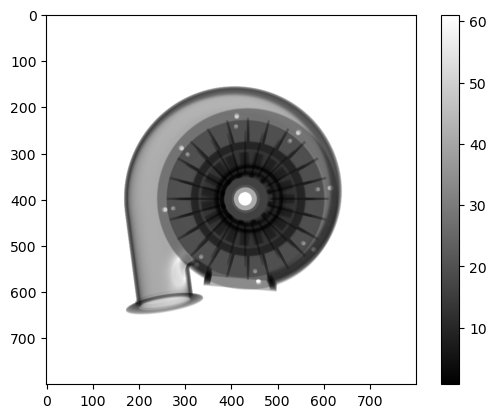

In [16]:
projection_in_MeV = np.array(gvxr.computeXRayImage(), dtype=np.single)
projection_in_keV = projection_in_MeV / gvxr.getUnitOfEnergy("keV")

fig = plt.figure()
plt.imshow(projection_in_keV, cmap="gray")
plt.colorbar()
plt.show()

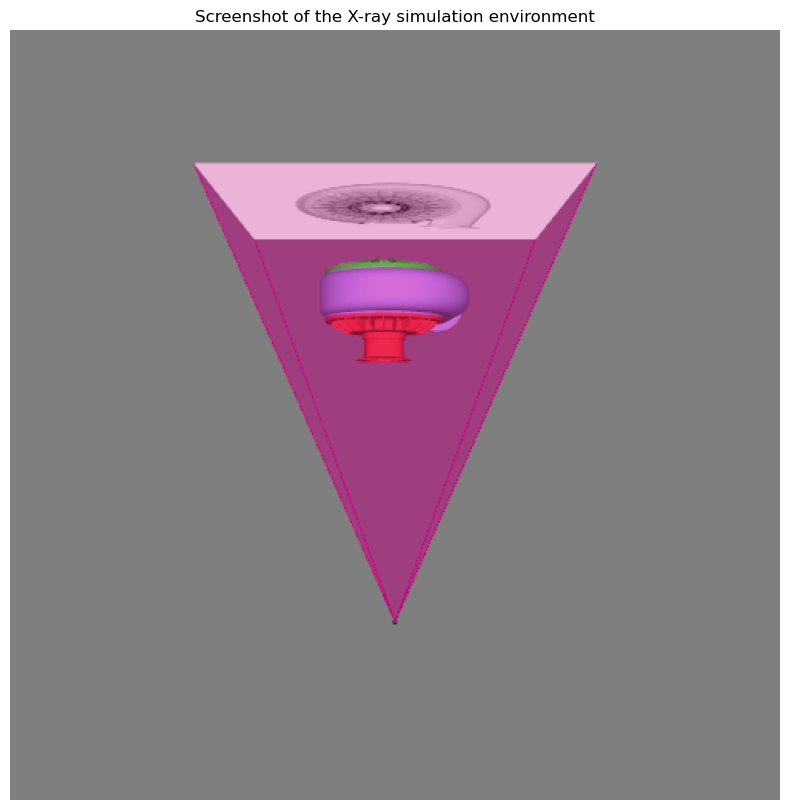

In [17]:
gvxr.displayScene()
     
plotScreenshot()

In [18]:
plot = visualise()
plot.display()

Output()

## Perfom the CT scan

In [19]:
raw_projection_output_dir = json2gvxr.getFilePath(json2gvxr.params["Scan"]["OutFolder"])
print("The raw projections were saved in", raw_projection_output_dir)

The raw projections were saved in /home/franck/PROGRAMMING/GitHub/gvxr-tutorials/JSON/../PoissonNoise/raw_projections


In [20]:
angles = json2gvxr.initScan()

Set up the CT Scan


In [21]:
number_of_angles = json2gvxr.params["Scan"]["NumberOfProjections"]

Has the CT scan been simulated?

In [22]:
projections_exist = True

for i in range(number_of_angles):
    fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    if not os.path.exists(fname):
        projections_exist = False

In [23]:
angles = json2gvxr.doCTScan()

## Add Poisson noise

1. Load the raw projection in the RAM
2. Convert the image in keV or MeV into number of photons
3. Add the Poisson noise
4. Convert the image in number of photons into keV or MeV
5. Apply the flat-field correction

In [24]:
def getNoisyImage(x_ray_image_energy, number_of_incident_photons_per_pixel, target_number_of_photons_per_pixel):
    
    global energy2photons
    
    temp = energy2photons / number_of_incident_photons_per_pixel * target_number_of_photons_per_pixel
    
    # Convert the image in keV into number of photons
    x_ray_image_photons = x_ray_image_energy * temp 
    
    # Add the Poisson noise
    noise_image = np.float32(np.random.poisson(x_ray_image_photons))

    # Convert in energy
    return noise_image / temp

Create the flat field image

In [25]:
number_of_flats = 50

if not os.path.exists(raw_projection_output_dir + "/../flat-field"):
    os.mkdir(raw_projection_output_dir + "/../flat-field")

fname = raw_projection_output_dir + "/../flat-field/flat.tif"
if False:#os.path.exists(fname):
    flat_field = imread(fname)
    
else:
    temp = total_energy_MeV * np.ones([1, number_of_rows, number_of_cols], dtype=np.single)
    flats = []

    for i in range(number_of_flats):
        flats.append(getNoisyImage(temp, number_of_incident_photons_per_pixel, target_number_of_photons_per_pixel))

    flat_field = np.average(flats, axis=0)

    imwrite(fname, flat_field.astype(np.single), compression='zlib')

In [26]:
if not os.path.exists(raw_projection_output_dir + "/../noisy_projections"):
    os.mkdir(raw_projection_output_dir + "/../noisy_projections")

raw_projections = []
for i in range(number_of_angles):

    print("Projection", i + 1, "/", number_of_angles, end='\r')

    input_fname = raw_projection_output_dir + "/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    output_fname = raw_projection_output_dir + "/../noisy_projections/projection-" + '{0:04d}'.format(i+1) + ".tiff"
    
    if False:#os.path.exists(output_fname):
        raw_projections.append(imread(output_fname))

    else:

        # Load the raw projection in the RAM
        x_ray_image_energy = imread(input_fname).astype(np.single)

        # Add the Poisson noise
        noise_image = getNoisyImage(x_ray_image_energy, number_of_incident_photons_per_pixel, target_number_of_photons_per_pixel)

        # Flat-field
        x_ray_image_energy = noise_image / flat_field[0]
        raw_projections.append(x_ray_image_energy.astype(np.single))

        # Save the image
        imwrite(output_fname, raw_projections[-1])

## CT reconstruction

In [27]:
def reconstruct(JSON_fname, verbose=0):
    
    reader = JSON2gVXRDataReader(file_name=JSON_fname)
    data = reader.read()

    if has_tigre:
        data.reorder(order='tigre')
    else:
        data.reorder("astra")

    ig = data.geometry.get_ImageGeometry()
    
    data_corr = TransmissionAbsorptionConverter(white_level=data.max())(data)

    source_shape = json2gvxr.params["Source"]["Shape"]

    if verbose > 0:
        print("Source shape:", source_shape)
    
    if type(source_shape) == str:

        if source_shape.upper() == "PARALLELBEAM" or source_shape.upper() == "PARALLEL":

            if verbose > 0: print("Parallel beam detected")

            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                reconstruction:ImageData | None = FBP(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                reconstruction:ImageData | None = FBP(data_corr, ig, backend="astra").run()

        elif source_shape.upper() == "POINTSOURCE" or source_shape.upper() == "POINT" or source_shape.upper() == "CONE" or source_shape.upper() == "CONEBEAM":

            if verbose > 0: print("Cone beam detected")

            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                reconstruction:ImageData | None = FDK(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                fbk = FDK_Flexible(ig, data_corr.geometry)
                fbk.set_input(data_corr)
                reconstruction:ImageData | None = fbk.get_output()

        else:
            raise ValueError("Unknown source shape:" + source_shape)

    elif type(source_shape) == type([]):
        if source_shape[0].upper() == "FOCALSPOT":

            if verbose > 0: print("Cone beam with focal spot detected")
            
            if has_tigre:
                if verbose > 0: print("Backend: Tigre")
                data_corr.reorder(order='tigre')
                reconstruction:ImageData | None = FDK(data_corr, ig).run()
            else:
                if verbose > 0: print("Backend: Astra-Toolbox")
                data_corr.reorder("astra")
                fbk = FDK_Flexible(ig, data_corr.geometry)
                fbk.set_input(data_corr)
                reconstruction:ImageData | None = fbk.get_output()

        else:
            raise ValueError("Unknown source shape:" + source_shape)

    else:
        raise ValueError("Unknown source shape:" + source_shape)    
        
    return data, reconstruction

In [28]:
has_tigre = False # Make sure we use astra
data, reconstruction = reconstruct("JSON/PoissonNoise.json", verbose=1)

[800, 800]
[0.8, 0.8]
Source shape: PointSource
Cone beam detected
Backend: Astra-Toolbox


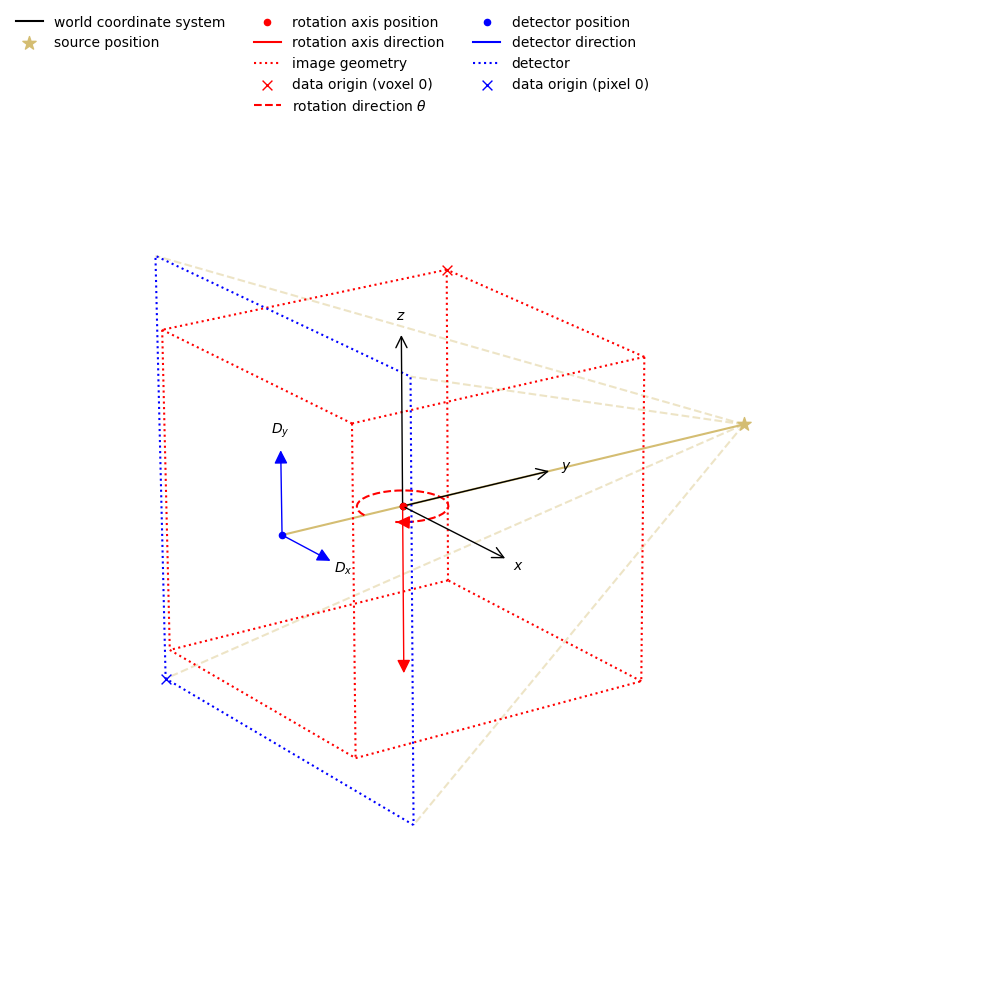

In [29]:
show_geometry(data.geometry)

In [30]:
islicer(reconstruction, direction='vertical')

In [31]:
islicer(reconstruction, direction='horizontal_x')

In [ ]:
fname = "PoissonNoise/reconstructions/CT_in_mu.mha"

if True:#not os.path.exists(fname):
    
    detector_size = np.array(gvxr.getDetectorSize("mm"))
    number_of_pixels = np.array(gvxr.getDetectorNumberOfPixels())
    spacing = detector_size / number_of_pixels
    sitk_image = sitk.GetImageFromArray(reconstruction.as_array())
    sitk_image.SetSpacing([spacing[0], spacing[0], spacing[1]])
    sitk.WriteImage(sitk_image, fname, useCompression=True)
    
    del sitk_image